# Introduction

**Problem Statment:**

Our model aims to predict the likelihood of thyroid cancer in patients using their medical and personal information, such as thyroid hormone levels (like TSH, T3, and T4), age, gender, family history, and environmental factors like radiation exposure. By analyzing this data, the model helps doctors determine whether a patient is at risk for thyroid cancer, allowing them to take early action and provide the appropriate treatment.

**Objective:**

The objective is to accurately predict whether a patient has thyroid cancer (Malignant) or not (Benign) based on their health data. By identifying patients at risk, this model will help healthcare professionals in early detection and personalized care, enabling timely interventions that could improve treatment outcomes and reduce cancer-related complications.

### Importing the libraries Required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, roc_curve, roc_auc_score,auc, confusion_matrix, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


### Loading the dataset

In [2]:
df = pd.read_csv('thyroid_cancer_risk_data.csv')
pd.set_option('display.max_columns', None)
display(df.shape)
df.head()

(212691, 17)

,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [3]:
# Examine data shape and info
print(df.info())

# Descriptive statistics
display(df.describe())

# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print('\n')
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size          212691 non-null  float64
 15  Thyroid_Cancer_Ri

,Patient_ID,Age,TSH_Level,T3_Level,T4_Level,Nodule_Size
count,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000
mean,106346.00000,51.918497,5.045102,2.001727,8.246204,2.503403
std,61398.74739,21.632815,2.860264,0.866248,2.164188,1.444631
min,1.00000,15.000000,0.100000,0.500000,4.500000,0.000000
25%,53173.50000,33.000000,2.570000,1.250000,6.370000,1.250000
50%,106346.00000,52.000000,5.040000,2.000000,8.240000,2.510000
75%,159518.50000,71.000000,7.520000,2.750000,10.120000,3.760000
max,212691.00000,89.000000,10.000000,3.500000,12.000000,5.000000


Patient_ID             0
Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64


0


In [4]:
# Numerical and Categorical features
numerical_features = df.select_dtypes(include=['number']).columns
print(numerical_features)
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['Patient_ID', 'Age', 'TSH_Level', 'T3_Level', 'T4_Level',
       'Nodule_Size'],
      dtype='object')
Index(['Gender', 'Country', 'Ethnicity', 'Family_History',
       'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity',
       'Diabetes', 'Thyroid_Cancer_Risk', 'Diagnosis'],
      dtype='object')


### Exploratory Data Analysis

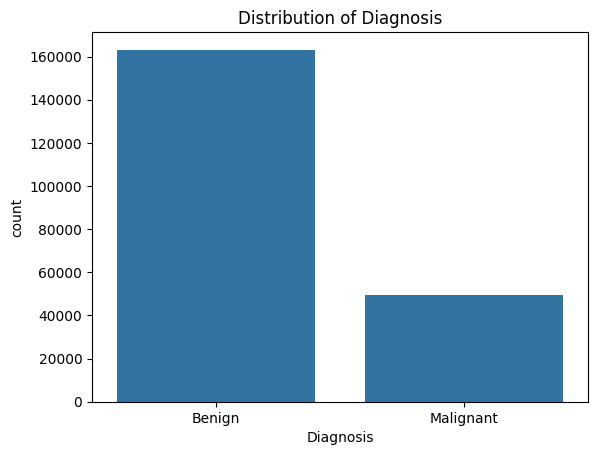

In [5]:
# Count of bening and malignant cases in the dataset
sns.countplot(x="Diagnosis", data=df)
plt.title("Distribution of Diagnosis")
plt.show()

Benign:

- It means the thyroid nodule growth is non-cancerous.

- It doesn't spread to other parts of the body.

- And usually not life-threatening and may not require aggressive treatment.

Malignant:

- It means the thyroid growth is cancerous.

- It can invade nearby tissues or spread to other areas.

- Requires more intensive treatment like surgery, radiation, or chemotherapy.

In [6]:
# Creating Age groups for comparisions
age_bins = [0, 40, 60, 100]
age_labels = ["below 40", "40-60", "60 Above"]
df["Age_Group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels)

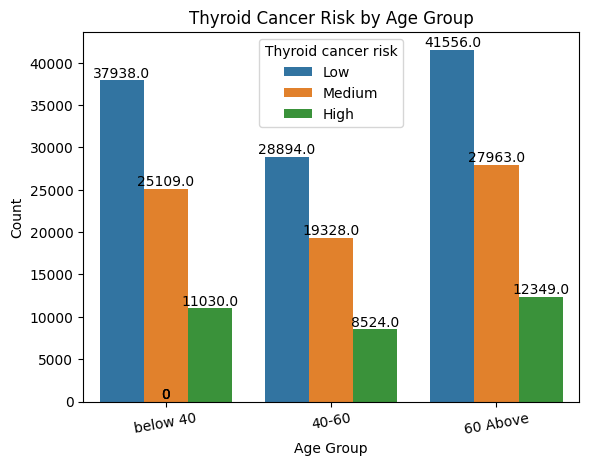

In [7]:
# Thyroid cancer risk by age group

risk_by_age = sns.countplot(x="Age_Group", data=df, hue="Thyroid_Cancer_Risk", hue_order=["Low", "Medium", "High"])

plt.title("Thyroid Cancer Risk by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=10)
plt.legend(title='Thyroid cancer risk')

for p in risk_by_age.patches:
  risk_by_age.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

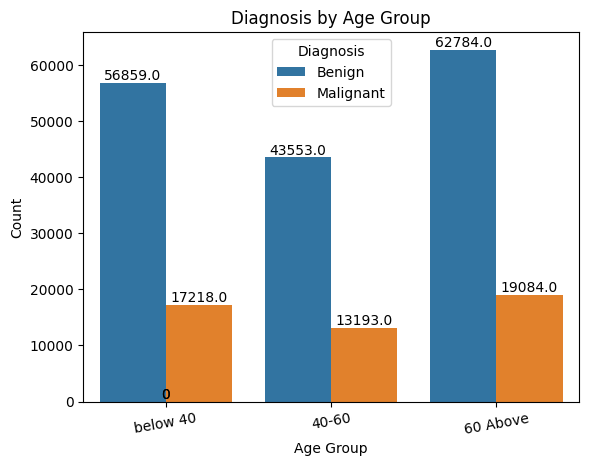

In [8]:
# Diagnosis of patients by age group

diagnosis_by_age = sns.countplot(x="Age_Group", data=df, hue="Diagnosis", hue_order=["Benign", "Malignant"])

plt.title("Diagnosis by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=10)
plt.legend(title='Diagnosis')

for p in diagnosis_by_age.patches:
  diagnosis_by_age.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

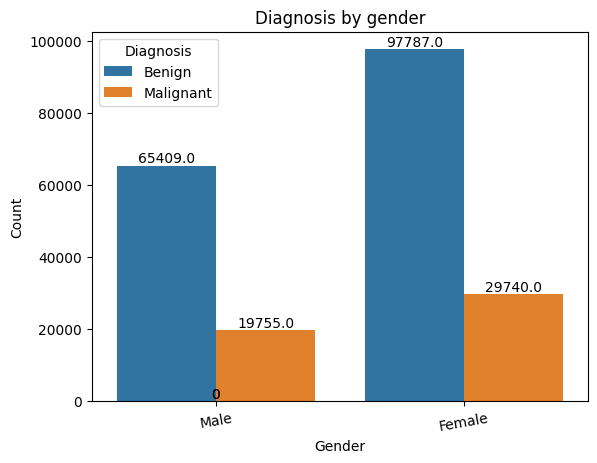

In [9]:
# Diagnosis of patients by gender

Diagnosis_by_gender = sns.countplot(x='Gender', data=df, hue='Diagnosis', hue_order=['Benign', 'Malignant'])

plt.title('Diagnosis by gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=10)
plt.legend(title='Diagnosis')

for p in Diagnosis_by_gender.patches:
  Diagnosis_by_gender.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

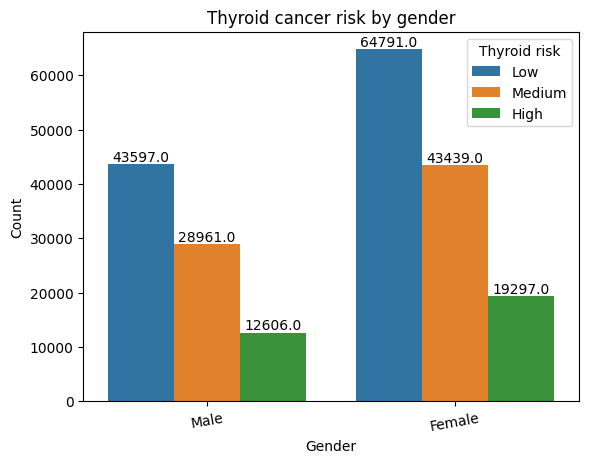

In [10]:
# Thyroid cancer risk by gender

Thyroid_by_gender = sns.countplot(x='Gender', data=df, hue='Thyroid_Cancer_Risk', hue_order=['Low', 'Medium', 'High'])

plt.title('Thyroid cancer risk by gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=10)
plt.legend(title='Thyroid risk')

for p in Thyroid_by_gender.patches:
    height = p.get_height()
    if height > 0:
        Thyroid_by_gender.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

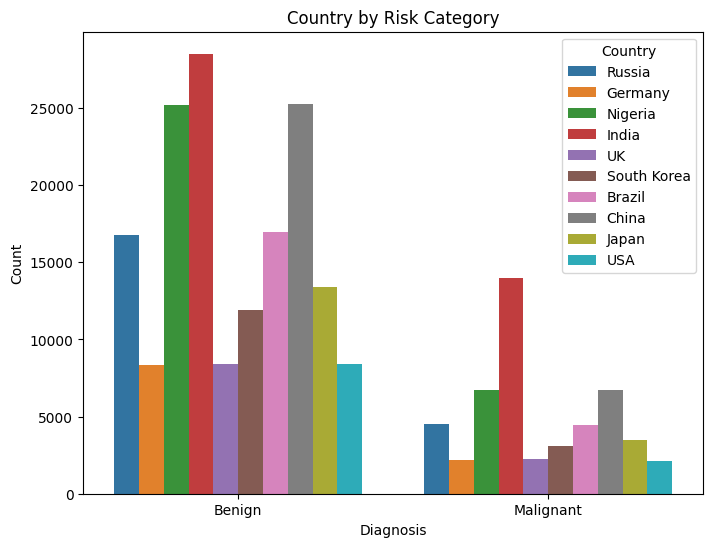

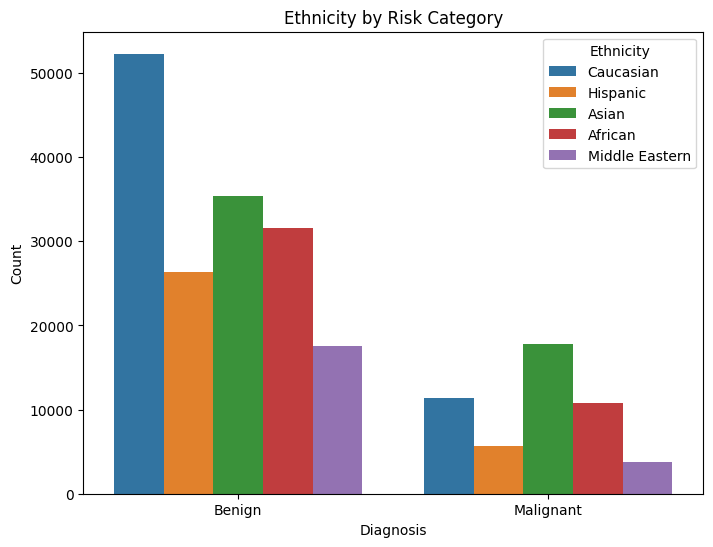

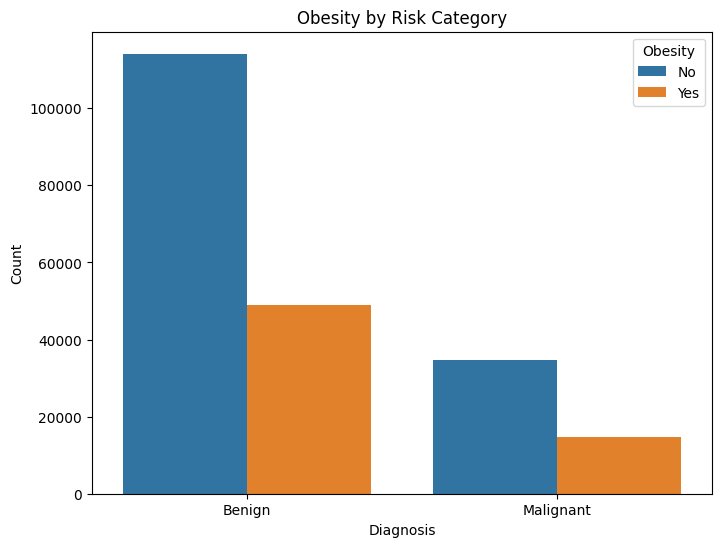

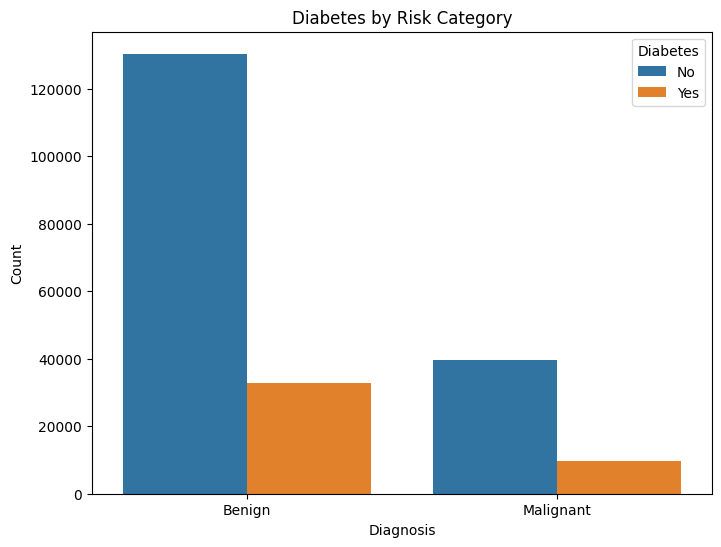

In [11]:
categorical_cols = ['Country', 'Ethnicity', 'Obesity', 'Diabetes']
# Visualizing categorical features vs. the target variable
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Diagnosis', hue=col, data=df)
    plt.title(f'{col} by Risk Category')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.show()
    print()

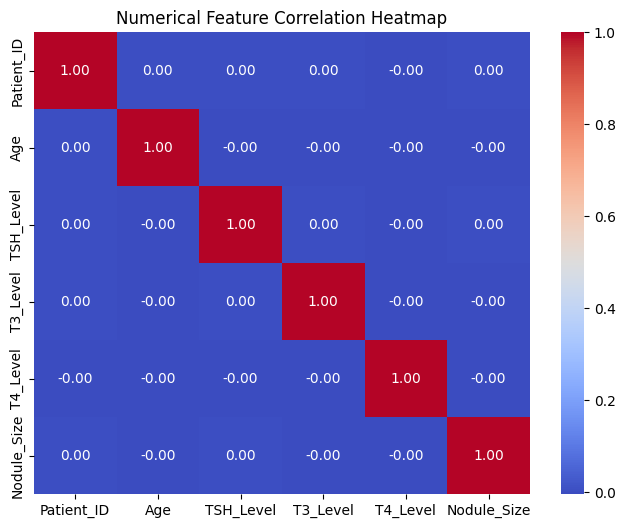

In [12]:
 # Numerical features correlation

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

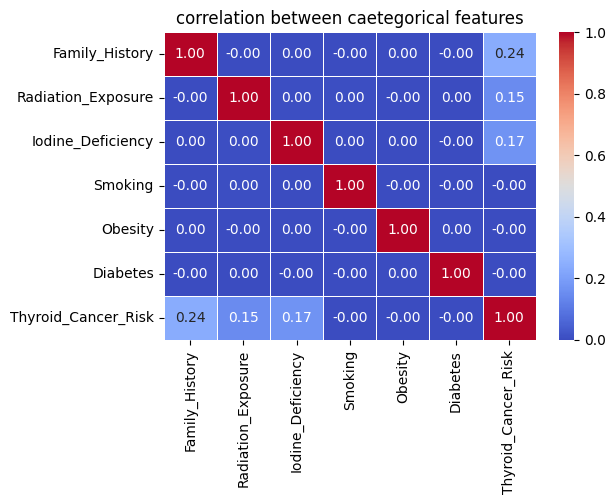

In [13]:
#  Categorical features correlation

category_encoding = {
    "Yes": 1, "No": 0,
    "Low": 0, "Medium": 1, "High": 2  # Ordinal encoding for risk levels
}

category_col = ['Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'Thyroid_Cancer_Risk']

data_encoded = df.copy()
for col in category_col:
  data_encoded[col] = data_encoded[col].map(category_encoding)

correlation_category = data_encoded[category_col].corr()

plt.figure(figsize=(6,4))
sns.heatmap(correlation_category, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.title('correlation between caetegorical features')
plt.show()

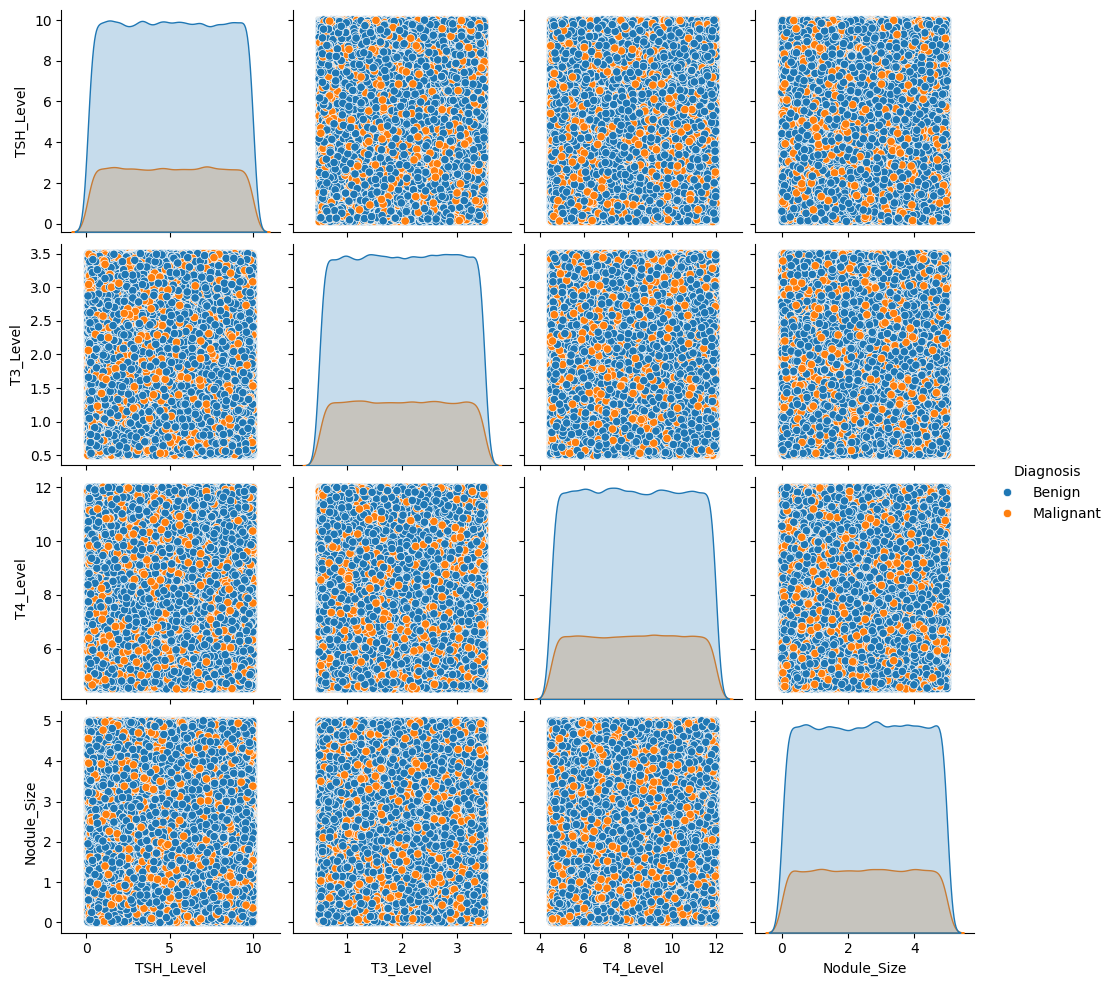

In [14]:
sns.pairplot(df, vars=['TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size'], hue='Diagnosis')

TSH Level (Thyroid Stimulating Hormone):

A hormone from the pituitary gland that regulates thyroid activity by stimulating the production of T3 and T4.

T3 Level (Triiodothyronine):

An active thyroid hormone that controls metabolism, heart rate, and body temperature.

T4 Level (Thyroxine):

The main thyroid hormone that helps regulate metabolism and is converted into T3 in the body.

Nodule Size: The physical size of a lump in the thyroid, which may indicate benign or malignant growth.

TSH_Level vs T3_Level / T4_Level
- Negative correlation is visible.

T3_Level vs T4_Level
- Positive linear trend - both increase together.

Nodule_Size vs All Hormones
- Malignant diagnoses tend to cluster at higher Nodule_Size values
- Benign diagnoses are often around smaller nodules.

### Data Cleaning

In [15]:
# Removing the unnecesary columns
dropping_columns=["Patient_ID", "Country", "Ethnicity", "Age_Group"]
df.drop(dropping_columns, axis=1, inplace=True)

In [16]:
list(df.columns)

['Age',
 'Gender',
 'Family_History',
 'Radiation_Exposure',
 'Iodine_Deficiency',
 'Smoking',
 'Obesity',
 'Diabetes',
 'TSH_Level',
 'T3_Level',
 'T4_Level',
 'Nodule_Size',
 'Thyroid_Cancer_Risk',
 'Diagnosis']

In [17]:
encoder = LabelEncoder()
categorical_columns = df.select_dtypes(include=["object"]).columns
print(categorical_columns)
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])
df

Index(['Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency',
       'Smoking', 'Obesity', 'Diabetes', 'Thyroid_Cancer_Risk', 'Diagnosis'],
      dtype='object')


,Age,Gender,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,1,0,1,0,0,0,0,9.37,1.67,6.16,1.08,1,0
1,29,1,0,1,0,0,0,0,1.83,1.73,10.54,4.05,1,0
2,86,1,0,0,0,0,0,0,6.26,2.59,10.57,4.61,1,0
3,75,0,0,0,0,0,0,0,4.10,2.62,11.04,2.46,2,0
4,35,0,1,1,0,0,0,0,9.10,2.11,10.71,2.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,0,0,0,0,0,1,0,2.00,0.64,11.92,1.48,1,0
212687,89,1,0,0,0,0,1,0,9.77,3.25,7.30,4.46,2,0
212688,72,0,0,0,0,0,0,1,7.72,2.44,8.71,2.36,2,0
212689,85,0,0,0,0,0,0,1,5.62,2.53,9.62,1.54,2,0


### Preprocessing the data

In [18]:
# Definining features and target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

# Split the dataset into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(y_train.value_counts())

Diagnosis
0    130556
1     39596
Name: count, dtype: int64


### Feature scaling

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SMOTE Resampling

In [20]:
# Before resampling the data
print(y_train.value_counts())

Diagnosis
0    130556
1     39596
Name: count, dtype: int64


In [21]:
# Model gets to learn from balanced data.
# It can now recognize both Benign and Malignant cases more accurately

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())

Diagnosis
1    130556
0    130556
Name: count, dtype: int64


In [22]:
class_distribution = y_train.value_counts()
print(class_distribution)

Diagnosis
1    130556
0    130556
Name: count, dtype: int64


### Defining the models

In [23]:
classification_algorithms = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression()
}

### Testing all the models and analysing the results

In [24]:
model_results = []
for name, model in classification_algorithms.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    time_taken = time.time() - start_time

    model_results.append([name, accuracy, precision, recall, f1, time_taken])

In [25]:
results_df = pd.DataFrame(model_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Time Taken (s)"])

# Display the final results table
print("\nModel Performance Summary:")
display(results_df.sort_values(by="F1-Score", ascending=False, ignore_index=True))


Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1-Score,Time Taken (s)
0,Gradient Boosting,0.829310,0.706610,0.455703,0.554075,104.847355
1,XGBoost,0.828581,0.703895,0.454591,0.552418,3.799833
2,Random Forest,0.808552,0.616241,0.469946,0.533242,135.099647
3,Naive Bayes,0.742307,0.454327,0.534094,0.490992,0.146344
4,Logistic Regression,0.660805,0.363702,0.610567,0.455859,0.284283
5,KNN,0.659889,0.358466,0.584503,0.444393,56.592162
6,Decision Tree,0.705353,0.377794,0.411456,0.393907,19.371010


### Select Best Model Based on F1-Score

### Model Selection Rationale:
Performance Metrics:

We chose Gradient Boosting for its exceptional performance, achieving the highest F1-score, which balances precision and recall. Compared to other models like XGBoost, Random Forest, and Logistic Regression, it demonstrated the best overall performance and accuracy, making it the most reliable choice for predicting thyroid cancer risk.

Model Characteristics:

Gradient Boosting is strong at handling complex data relationships and can learn from its mistakes, which helps it become more accurate over time. It's a good choice when dealing with data where the patterns aren't straightforward. The model works well for classification tasks.



In [26]:
best_performance_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
selected_classifier = classification_algorithms[best_performance_model]
print(f"Best performed Model: {best_performance_model}")

Best performed Model: Gradient Boosting


In [27]:
model = GradientBoostingClassifier(random_state=43)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=43)

In [28]:
y_test_prediction = model.predict(X_test)
accuracy_testing = accuracy_score(y_test, y_test_prediction)
print(accuracy_testing)

0.8293095747431769


In [29]:
print(classification_report(y_test, y_test_prediction))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32640
           1       0.71      0.46      0.55      9899

    accuracy                           0.83     42539
   macro avg       0.78      0.70      0.72     42539
weighted avg       0.82      0.83      0.82     42539



### Confusion Matrix

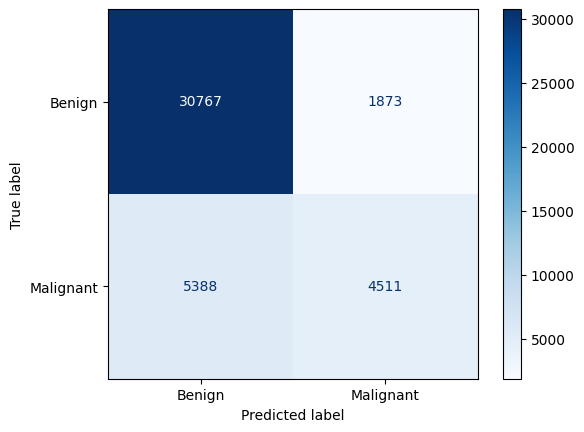

In [30]:
conf_mat = confusion_matrix(y_test, y_test_prediction)
conf_graph = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Benign", "Malignant"])
conf_graph.plot(cmap='Blues')
plt.show()

In [31]:
# 30767 (True Negatives - TN): The model correctly predicted Benign cases as Benign.

# 1873 (False Positives - FP): The model incorrectly predicted Benign cases as Malignant. These are the false positives.

# 5388 (False Negatives - FN): The model incorrectly predicted Malignant cases as Benign. These are the false negatives.

# 4511 (True Positives - TP):  The model correctly predicted Malignant cases as Malignant.

### ROC-AUC Curve

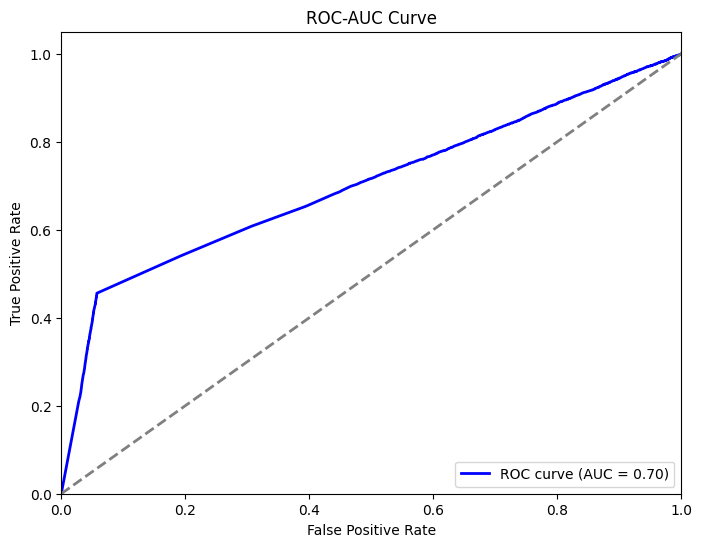

In [32]:
# We Get the predicted probabilities for the positive class (1 - Malignant)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve (Reciever Operating Characteristics)
# (True Positive Rate (TPR) against the False Positive Rate (FPR))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()


In [33]:
# AUC values range from 0 to 1:

# AUC = 0.5: The model is no better than random guessing.
# AUC = 1: The model has perfect performance.
# AUC < 0.5: The model performs worse than random guessing.

In [34]:
# interpretability: Interpretability refers to the ability to understand why a model made a certain decision
# Explainability refers to the ability to explain how a model arrived at a decision

# Techniques
# SHAP (SHapley Additive exPlanations)
# LIME (Local Interpretable Model-agnostic Explanations)

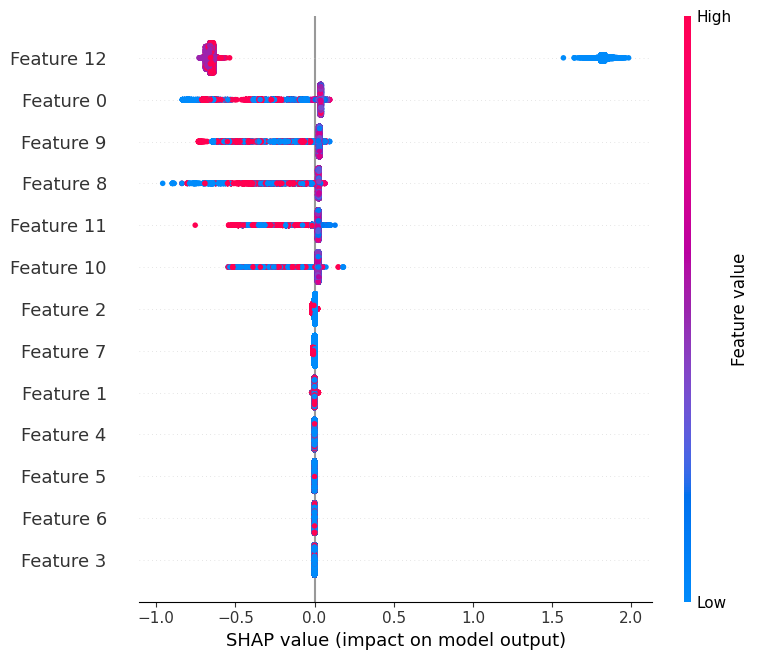

In [35]:
import shap

# Seting up the SHAP explainer for the Gradient Boosting model
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_feature_values = explainer.shap_values(X_test)

shap.summary_plot(shap_feature_values, X_test)
